Project: Write a Data Science Blog Post

# Section 1: Business Understanding:
In our IT organization, one of our objectives to resolve incidents as soon as possible to ensure minimal disruption for our business partners
The incident resolution times cannot be directly related because the resolution time depend on the context of the ticket: Priority, Agreed service level, ...

### Question 1. What are the factors that influence the time to resolve incident tickets the most?
### Question 2. Is there a difference in ticket resolution time between vendors?
### Question 3. Can customer satisfaction be related to the resolution time?
### Question 4. Does ticket reassignment between groups and staff members affect the resolution time?

### Approach:
1. The incident data has been extracted from an Enterpise Data Lake
2. Data cleaning
3. Predict the incident resolution times based on the ticket context: Priority, Service Level, ... by means of a linear model
4. Evaluate all remaining categorical variables against the difference between actual and predicted resolution times by means of 1 Sample Ttest

In [1]:
# Import the applicable libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import seaborn as sns
%matplotlib inline

# Section 2: Data Understanding
### Gather Incident Data
Load file "Incidents.xlsx" which is extracted from the EDL which holds the ticket data

In [2]:
# Load the Incident data
df_incidents = pd.read_excel("Incidents.xlsx")
df_incidents[["global_ttr_seconds","appl_tier","priority","assignment_group_company","assignment_group", "csat_completed", "csat_score", "reassignment_count"]].head(5)

,global_ttr_seconds,appl_tier,priority,assignment_group_company,assignment_group,csat_completed,csat_score,reassignment_count
0,1864672,Silver,Priority 4,VEND_B,CBT RR VB,NaN,NaN,0
1,41028,Gold,Priority 3,VEND_D,ERP RR VD,NaN,NaN,0
2,406967,Gold,Priority 4,VEND_B,ERP RR VB - BTB LATAM,NaN,NaN,0
3,173826,Gold,Priority 3,VEND_B,ERP RR VB - USROTC,NaN,NaN,0
4,97739,Silver,Priority 4,VEND_B,CBT RR VB,NaN,NaN,1


# Section 3: Data Preparation
#### Assess & Clean data: Incident resolution time

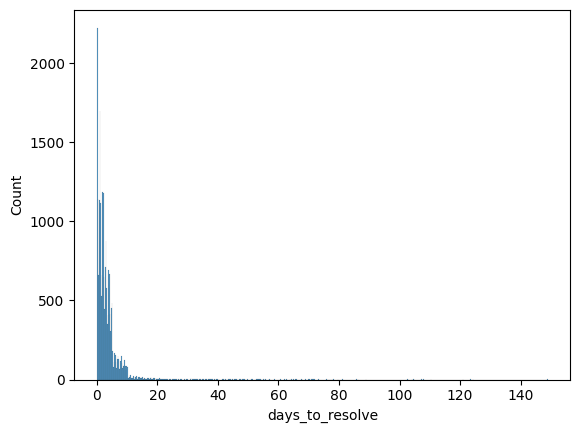

In [3]:
# Convert time to resolve from seconds to days (since is a more intuitive metric)
df_incidents["days_to_resolve"]=df_incidents["global_ttr_seconds"]/3600/24
df_incidents.drop(columns="global_ttr_seconds", inplace=True)

# Histogram of the time to resolve values
sns.histplot(data=df_incidents,x="days_to_resolve")
plt.show()

The incident resolution time is highly right-skewed (a limited number of tickets take a lot of time)

Solution: Exclude the top 5% of incidents (time to resolve) to reduce the right-skewing

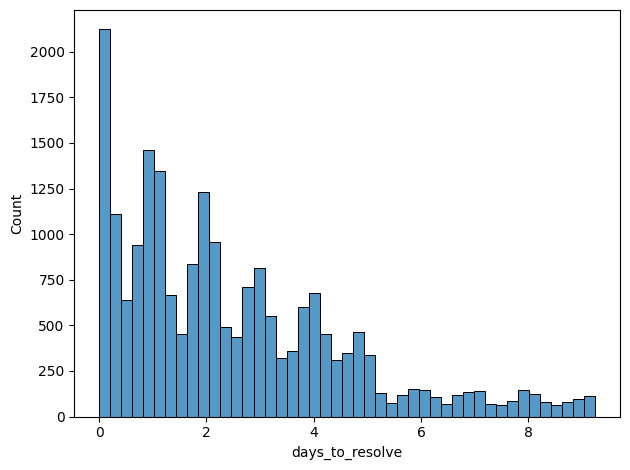

In [4]:
df_incidents = df_incidents[df_incidents["days_to_resolve"]<df_incidents["days_to_resolve"].quantile(0.95)]
sns.histplot(data=df_incidents,x="days_to_resolve")
plt.tight_layout()
plt.savefig("days_to_resolve.png", dpi=150)

#### Assess & Clean data: Categorical values to serve as the input for the Linear Model

In [5]:
# Define the categorical variables to be used as the input to the linear model
linear_model_vars = ["appl_tier","priority","contact_type","inc_close_code"]

def print_categorical_value_counts(df,vars):
    '''
    Prints the values and their number of occurences for all of the categorical columns provided

    input:
        df - the dataframe to be checked
        var - the categorical variables for which to list the values
    output: 
        none   
    '''
    for var in vars:
        print ("variable:", var)
        print (df[var].value_counts(dropna=False))
        print ("--------")
    return

print_categorical_value_counts(df_incidents,linear_model_vars)

variable: appl_tier
Gold      9912
Silver    9490
Bronze     945
NaN        312
Iron        93
Name: appl_tier, dtype: int64
--------
variable: priority
Priority 4    12275
Priority 3     8454
Priority 2       23
Name: priority, dtype: int64
--------
variable: contact_type
self-service             8432
Event Management         6230
chat                     3410
phone                    1348
walk-in                  1269
Bright Red                 39
Proactive Operations       17
mobile                      3
Scheduled Appointment       2
Bright Red Live             2
Name: contact_type, dtype: int64
--------
variable: inc_close_code
Information Provided / Training    9826
Data Correction                    5915
Reboot / Restart                   3339
Security Modification               884
Software Correction                 520
Environmental Restoration           202
Capacity Adjustment                  53
Hardware Correction                  10
Redundancy Activation                 3

Based on an analysis of the data:
-  Insufficient ticket in Iron and Nan: Retain the only those tickets that are in the 3 major application tiers: Gold, Silver, Bronze
-  Insufficient tickets in Priority 2: Retain the only those tickets that have the 2 major priorities: Priority 3, Priority 4
-  Insufficient tickets for certain values in contact_type inc_close_code: Reclassify the categorical values with less then 100 occurences as 'other'

In [6]:
df_incidents = df_incidents[df_incidents["appl_tier"].isin(["Gold","Silver","Bronze"])]

df_incidents = df_incidents[df_incidents["priority"].isin(["Priority 3","Priority 4"])]

df_incidents = df_incidents.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'other') 
    if x.name in linear_model_vars else x)

print_categorical_value_counts(df_incidents,linear_model_vars)

variable: appl_tier
Gold      9901
Silver    9479
Bronze     944
Name: appl_tier, dtype: int64
--------
variable: priority
Priority 4    12081
Priority 3     8243
Name: priority, dtype: int64
--------
variable: contact_type
self-service        8348
Event Management    5979
chat                3351
phone               1322
walk-in             1262
other                 62
Name: contact_type, dtype: int64
--------
variable: inc_close_code
Information Provided / Training    9686
Data Correction                    5743
Reboot / Restart                   3260
Security Modification               871
Software Correction                 508
Environmental Restoration           191
other                                65
Name: inc_close_code, dtype: int64
--------


#### Assess & Clean data: Categorical values for which to determine their impact on resolution timelines

In [7]:
# the variables for which to determine their correlation with the resolution time = all remaining variables
evaluate_catvars = list(set(df_incidents.columns)-set(linear_model_vars)-set(["days_to_resolve"]))

print_categorical_value_counts(df_incidents,evaluate_catvars)

variable: kcs_solution
NaN               9805
KB000010101714     257
KB000010056321     249
KB000010084253     186
KB000010111606     160
                  ... 
KB000010106475       1
KB000010128037       1
KB000010070604       1
KB000010067350       1
KB000010078087       1
Name: kcs_solution, Length: 2266, dtype: int64
--------
variable: label
English       19563
Spanish         245
Portuguese      232
Chinese         172
Japanese        112
Name: label, dtype: int64
--------
variable: dv_u_zcode
Z999442    5258
Z999437    2574
Z999932    1410
Z998688    1155
Z999008    1148
           ... 
Z998601       1
Z999964       1
Z999519       1
Z999381       1
Z999191       1
Name: dv_u_zcode, Length: 95, dtype: int64
--------
variable: assignment_group
CBT RR VB                        3876
ERP RR VA                        1583
CBT RR VC                        1357
ERP RR VD                        1234
CUST AND SALES RR VC             1215
CBT RR VA                        1180
RSCH AND DEV 

Actions based on the obversations:
- csat_completed and csat_core have NaN values (user didn't provide feedback): replace with 0 to enable evaluation
- region fields "NA" values have become 'NaN': replace NaN with 'NA'
- most of the incidents relate to the 'Production' environment, collapse all other environments to "Non-Production" given the low occurence
- breached_reason_code is NaN when ticket is not breached: replace with "Not breached"
- replace the NaN values for parent_bs_sub_product_line with "No sub product line"
- replace the NaN values for dv_u_coe with "No coe"

In [8]:
df_incidents[["csat_completed"]] = df_incidents[["csat_completed"]].fillna(0)
df_incidents[["csat_score"]] = df_incidents[["csat_score"]].fillna(0)
df_incidents[["caller_requester_region"]] = df_incidents[["caller_requester_region"]].fillna("NA")
df_incidents[["dv_u_region"]] = df_incidents[["dv_u_region"]].fillna("NA")
df_incidents[["rgn_nm"]] = df_incidents[["rgn_nm"]].fillna("NA")
df_incidents.loc[df_incidents["appl_environment"]!="Production","appl_environment"] = "Non-Production"
df_incidents[["breached_reason_code"]] = df_incidents[["breached_reason_code"]].fillna("Not breached")
df_incidents[["parent_bs_sub_product_line"]] = df_incidents[["parent_bs_sub_product_line"]].fillna("No sub product line")
df_incidents[["dv_u_coe"]] = df_incidents[["dv_u_coe"]].fillna("No coe")

print_categorical_value_counts(df_incidents,evaluate_catvars)

variable: kcs_solution
NaN               9805
KB000010101714     257
KB000010056321     249
KB000010084253     186
KB000010111606     160
                  ... 
KB000010106475       1
KB000010128037       1
KB000010070604       1
KB000010067350       1
KB000010078087       1
Name: kcs_solution, Length: 2266, dtype: int64
--------
variable: label
English       19563
Spanish         245
Portuguese      232
Chinese         172
Japanese        112
Name: label, dtype: int64
--------
variable: dv_u_zcode
Z999442    5258
Z999437    2574
Z999932    1410
Z998688    1155
Z999008    1148
           ... 
Z998601       1
Z999964       1
Z999519       1
Z999381       1
Z999191       1
Name: dv_u_zcode, Length: 95, dtype: int64
--------
variable: assignment_group
CBT RR VB                        3876
ERP RR VA                        1583
CBT RR VC                        1357
ERP RR VD                        1234
CUST AND SALES RR VC             1215
CBT RR VA                        1180
RSCH AND DEV 

### Analyze

Review the resolution time ranges for the categorical variables to be used as input to the linear model

<AxesSubplot:xlabel='days_to_resolve', ylabel='appl_tier'>

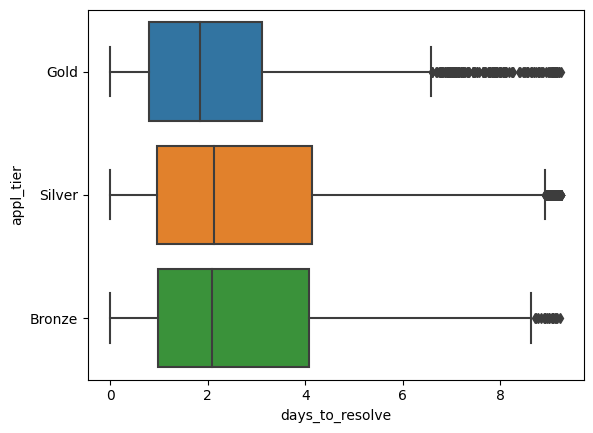

In [9]:
sns.boxplot(data=df_incidents,y="appl_tier", x="days_to_resolve")

<AxesSubplot:xlabel='days_to_resolve', ylabel='priority'>

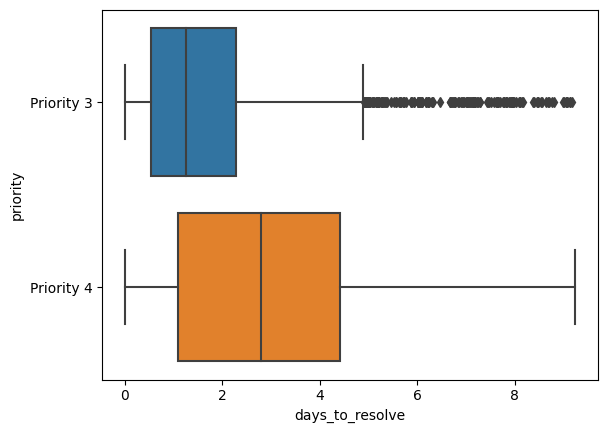

In [10]:
sns.boxplot(data=df_incidents,y="priority", x="days_to_resolve")

<AxesSubplot:xlabel='days_to_resolve', ylabel='contact_type'>

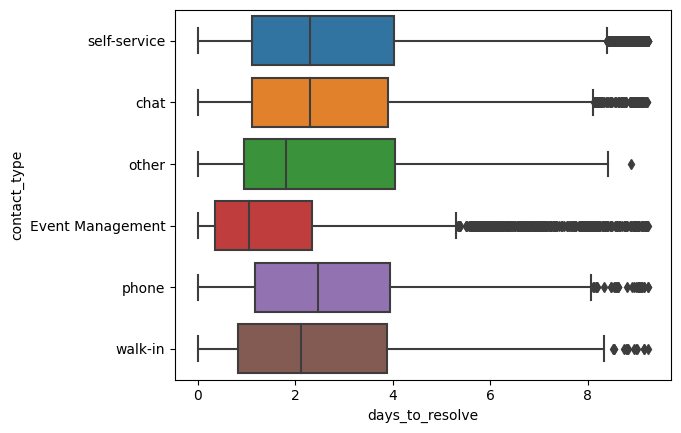

In [11]:
sns.boxplot(data=df_incidents,y="contact_type", x="days_to_resolve")

Observation: 
- The resolution times for event management are significantly lower then those for the other contact types
- The days to resolve for the other contact types are insufficiently differentiated

Action: lump contact types different from "Event Management" under 'Other' category

<AxesSubplot:xlabel='days_to_resolve', ylabel='contact_type'>

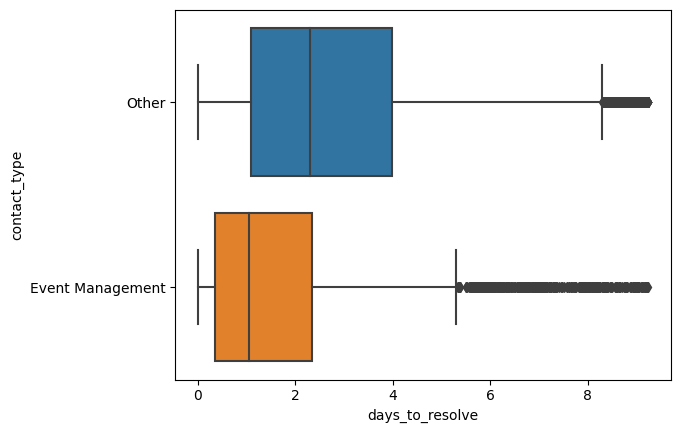

In [12]:
df_incidents.loc[df_incidents["contact_type"]!="Event Management","contact_type"] = "Other"
sns.boxplot(data=df_incidents,y="contact_type", x="days_to_resolve")

# Section 4: Data modeling
### Model: Linear Model

Define the X and y inputs to the Linear model:
-  X: Create dummy variables for the defined categorical variables
-  y: Retain days_to_resolve

In [13]:
# Dummy the categorical variables to be used as input for the linear model
for var in  linear_model_vars:
    df_incidents = pd.concat([df_incidents, pd.get_dummies(df_incidents[var], prefix=var, prefix_sep='__', drop_first=True, dummy_na=False)], axis=1)

# Retain the dummy categorical variables with '__' in their name as the X matrix
X_cols = [col for col in df_incidents.columns if '__' in col]
X = df_incidents[X_cols]

# Retain the time to resolve as the target variable
y = df_incidents['days_to_resolve']

Create the Linear model and provide the Rsquared results for both training and test data

In [14]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Instantiate the linear model and fit to the train values
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

#Predict using linear model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using linear model
r2_test = r2_score(y_test, y_test_preds)
r2_train = r2_score(y_train, y_train_preds)

print("Rsquared training data: {:.3f}.  Rsquared test data: {:.3f}".format(r2_train, r2_test))

Rsquared training data: 0.226.  Rsquared test data: 0.229


### Validate linear model

Rsquared results are almost the same for training and test data which indicates the model is fit for purpose

List the model coefficients in order to validate them against the above boxplots

In [15]:
#Store the coefficients in an Excel file
def coef_weights(coefficients, X_train):
    '''
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.

    input:
        coefficients - the coefficients of the linear model 
        X_train - the training data, so the column names can be used
    output:
        coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#Export the coefficients to Excel
coef_df.to_excel("IncidentDuration_coef.xlsx")

coef_df

,est_int,coefs
2,priority__Priority 4,1.347159
3,contact_type__Other,0.645487
5,inc_close_code__Information Provided / Training,0.058994
1,appl_tier__Silver,-0.018209
8,inc_close_code__Software Correction,-0.146207
4,inc_close_code__Environmental Restoration,-0.254120
9,inc_close_code__other,-0.369844
7,inc_close_code__Security Modification,-0.503329
0,appl_tier__Gold,-0.824667
6,inc_close_code__Reboot / Restart,-0.991531


The model coefficients match with above boxplots.

Use the linear model to calculate the predicted resolution times
Calculate the difference between the actual and predicted resolution time

In [16]:
#Calculate the predicted time to resolve by applying the model to the original dataset
df_incidents["predicted_days_to_resolve"] = lm_model.predict(df_incidents[X_cols])

#Calculate the difference between the actual and predicted time to resolve
df_incidents["resolution_days_difference"] = df_incidents["days_to_resolve"]-df_incidents["predicted_days_to_resolve"]

Visualize the distribution of the differences

Mean resolution time: -0.01 days = -0.25 hours


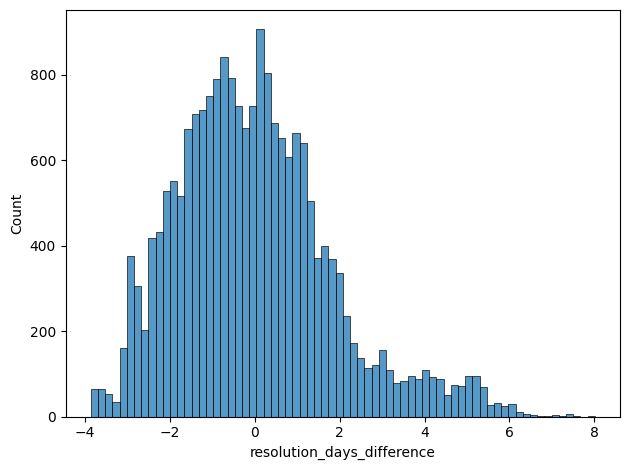

In [17]:
#Check the distribution of the calculated diff values through a histogram (centered around 0)
#Eliminate the outlier values since we are interested in the normal process behavior
resolution_time_mean_days = df_incidents["resolution_days_difference"].mean()
resolution_time_mean_hours = df_incidents["resolution_days_difference"].mean()*24
print("Mean resolution time: {:.2f} days = {:.2f} hours".format(resolution_time_mean_days,resolution_time_mean_hours))
sns.histplot(data=df_incidents,x="resolution_days_difference")
plt.tight_layout()
plt.savefig("time_to_resolve_actual_minus_expected.png", dpi=150)

The differences are centered around 0.01 days (0.25 hours) and have a 'normal' distribution curve

This enables to perform a "1 Sample Ttest" statistic on the remaining categorical variables:
-  H0 Hypothesis: the mean incident resolution time is 0.01 (resolution_time_mean_days)
-  Alternative Hypothesis 1: the mean incident resolution time is greater than 0.01 (resolution_time_mean_days)
-  Alternative Hypothesis 2: the mean incident resolution time is small than 0 (resolution_time_mean_days)

### Apply 1 Sample Ttest Statistic

Statistic: 1 Sample Ttest to check if mean is greater than 'resolution_time_mean_days'

Create a new dataframe to collect the statistics for every Variable-Value combination
Leave out Variable-Value records with fewer than 25 rows

In [18]:
df_col_values_analysis = pd.DataFrame(columns=["Variable","Value","Count","Mean","Ttest","p_increase","p_decrease","Assessment"])

for col in evaluate_catvars:
    for value in df_incidents[col].unique():        
        if df_incidents[df_incidents[col]==value]["resolution_days_difference"].shape[0]>25:
            t_increase, p_increase =  stats.ttest_1samp(df_incidents[df_incidents[col]==value]["resolution_days_difference"],
                popmean=resolution_time_mean_days,
                alternative='greater')
            t_decrease, p_decrease =  stats.ttest_1samp(df_incidents[df_incidents[col]==value]["resolution_days_difference"],
                popmean=resolution_time_mean_days,
                alternative='less')
            new_row = {
                "Variable":col, 
                "Value":value, 
                "Count":df_incidents[df_incidents[col]==value].shape[0],
                "Mean": df_incidents[df_incidents[col]==value]["resolution_days_difference"].mean(),
                "Ttest": t_increase,
                "p_increase": p_increase, 
                "p_decrease": p_decrease}
            df_col_values_analysis = df_col_values_analysis.append(new_row, ignore_index=True)

p_limit = 0.05

df_col_values_analysis.loc[df_col_values_analysis["p_increase"]<p_limit,"Assessment"] = "Increased Resolution Time"
df_col_values_analysis.loc[df_col_values_analysis["p_decrease"]<p_limit,"Assessment"] = "Decreased Resolution Time"

df_col_values_analysis = df_col_values_analysis.round(3)

Store the statistics sorted by the calculated p value in an Excel file with 2 separate sheet:
-  One sheet for the increases
-  Other sheet for the decreases

In [19]:
with pd.ExcelWriter("Factors influencing time_to_resolve.xlsx") as writer:
    df_col_values_analysis.sort_values(by=["p_increase","Mean"], ascending=[True,True],inplace=True)
    df_col_values_analysis.to_excel(writer,sheet_name="Factors with increased TTR.xlsx")
    df_col_values_analysis.sort_values(by=["p_decrease","Mean"], ascending=[True,False], inplace=True)
    df_col_values_analysis.to_excel(writer,sheet_name="Factors with decreased TTR.xlsx")

# Section 5: Evaluate the results

### Question 1. What are the factors that influence the time to resolve incident tickets the most?
Analyse and Visualise

In [20]:
# Analyse: Factors leading to decreased resolution time
df_col_values_analysis.sort_values(by=["p_decrease","Mean"], ascending=[True,True],inplace=True)
# Visualise
df_col_values_analysis[df_col_values_analysis["Assessment"]=="Decreased Resolution Time"].round(3).head(15)

,Variable,Value,Count,Mean,Ttest,p_increase,p_decrease,Assessment
287,prod_appl_name,SCAN2HEALTH - PROD,84,-2.293,-16.203,1.0,0.0,Decreased Resolution Time
3,kcs_solution,KB000010049710,104,-2.207,-36.698,1.0,0.0,Decreased Resolution Time
168,prod_appl_name,ECOUP - PROD,150,-2.161,-40.346,1.0,0.0,Decreased Resolution Time
131,assignment_group,ERP RR VC,154,-2.119,-33.796,1.0,0.0,Decreased Resolution Time
38,kcs_solution,KB000010101373,28,-1.866,-9.454,1.0,0.0,Decreased Resolution Time
273,prod_appl_name,ONEMDR-DATA MANAGEMENT-PROD,34,-1.836,-38.339,1.0,0.0,Decreased Resolution Time
67,kcs_solution,KB000010107114,29,-1.822,-33.301,1.0,0.0,Decreased Resolution Time
23,kcs_solution,KB000010052515,40,-1.685,-14.786,1.0,0.0,Decreased Resolution Time
223,prod_appl_name,ONEMDRAAR-PROD,40,-1.685,-14.786,1.0,0.0,Decreased Resolution Time
87,dv_u_zcode,Z999771,144,-1.671,-21.745,1.0,0.0,Decreased Resolution Time


Explanation:
- kcs_solution: these are knowledge articles used by support staff > so good candidates for deeper investigation
- prod_appl_name, assignment_group: are other opportunities for deeper analysis (understand the reason for the decreased resolution time)

In [21]:
# Analyse: Factors leading to increased resolution time
df_col_values_analysis.sort_values(by=["p_increase","Mean"], ascending=[True,False],inplace=True)
# Visualise:
df_col_values_analysis[df_col_values_analysis["Assessment"]=="Increased Resolution Time"].round(3).head(20)

,Variable,Value,Count,Mean,Ttest,p_increase,p_decrease,Assessment
154,breached_reason_code,3rd Party or External Event,199,4.081,37.165,0.0,1.0,Increased Resolution Time
374,sla_stage,Breached,426,3.959,49.837,0.0,1.0,Increased Resolution Time
156,breached_reason_code,Received late or Breached,90,3.846,22.984,0.0,1.0,Increased Resolution Time
157,breached_reason_code,Complex Resolution,41,3.837,16.261,0.0,1.0,Increased Resolution Time
155,breached_reason_code,Customer Delay,85,3.580,20.604,0.0,1.0,Increased Resolution Time
215,prod_appl_name,CONTRACT MANAGER - CM SAAS,28,2.442,5.328,0.0,1.0,Increased Resolution Time
224,prod_appl_name,ASPAC DNA PLATFORM,59,2.423,9.233,0.0,1.0,Increased Resolution Time
101,dv_u_zcode,Z999203,39,2.176,5.800,0.0,1.0,Increased Resolution Time
39,kcs_solution,KB000010090155,56,2.169,19.576,0.0,1.0,Increased Resolution Time
347,reassignment_count,5,33,2.086,5.080,0.0,1.0,Increased Resolution Time


Explanation:
- sla_stage:'Breached' tickets are 'by definition' those that have taken more that the agreed SLA time. So it is logical that these appear at the top of the list.
- breached_reason_code: same reasoning
- reassignment_count: 5 : frequent reassignment analysed as a separate question
- kcs_solution: these are knowledge articles used by support staff > so good candidates for deeper investigation
- prod_appl_name, assignment_group: are other opportunities for deeper analysis

### Question 2. Is there a difference in ticket resolution time between vendors?
Analyse and visualise through boxplot and table

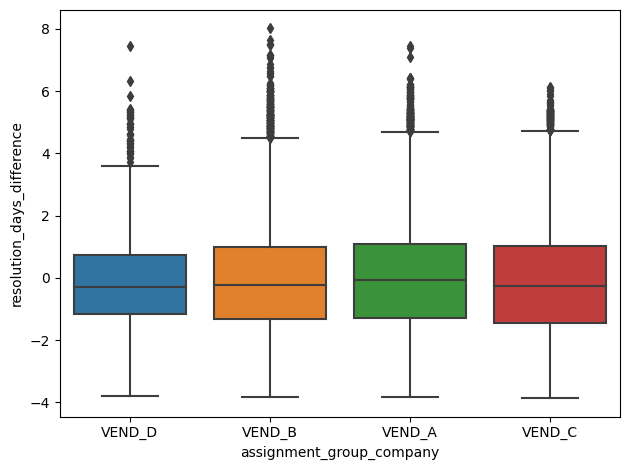

In [22]:
sns.boxplot(data=df_incidents,x="assignment_group_company", y="resolution_days_difference")
plt.tight_layout()
plt.savefig("assignment_group_company_time_to_resolve.png", dpi=150)

In [23]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="assignment_group_company"].round(3)

,Variable,Value,Count,Mean,Ttest,p_increase,p_decrease,Assessment
435,assignment_group_company,VEND_A,6902,0.064,3.298,0.000,1.000,Increased Resolution Time
434,assignment_group_company,VEND_B,7301,-0.021,-0.491,0.688,0.312,NaN
436,assignment_group_company,VEND_C,3812,-0.036,-0.804,0.789,0.211,NaN
433,assignment_group_company,VEND_D,2309,-0.156,-4.915,1.000,0.000,Decreased Resolution Time


Explanation:
- Vendor D has automated the ticket assignment to their staff based on availability and workload. This may explain the decreased resolution time.
- Vendor A: Remaining Action: analyse the underpinning support groups and applications

### Question 3. Can customer satisfaction be related to the resolution time?

Users can provide a satisfaction score 1 .. 5 upon resolution of an incident.

Satisfaction score 0 = No response provided

Analyse and visualise through boxplot and table

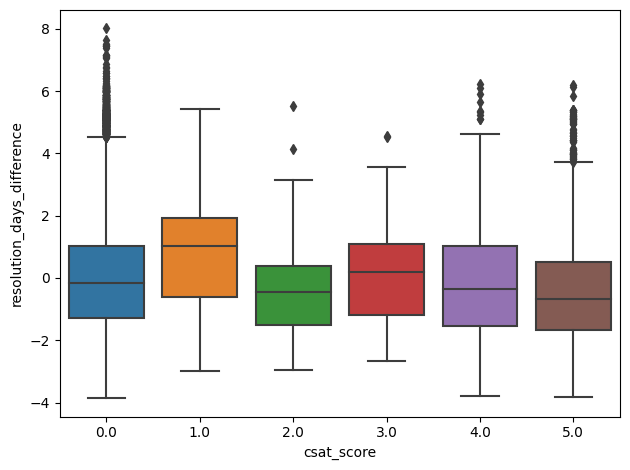

In [24]:
sns.boxplot(data=df_incidents,x="csat_score", y="resolution_days_difference")
plt.tight_layout()
plt.savefig("customer_satisfaction_time_to_resolve.png", dpi=150)

In [25]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="csat_score"].round(3)

,Variable,Value,Count,Mean,Ttest,p_increase,p_decrease,Assessment
352,csat_score,1.0,77,0.897,3.913,0.000,1.000,Increased Resolution Time
348,csat_score,0.0,18604,0.014,1.817,0.035,0.965,Increased Resolution Time
350,csat_score,3.0,68,0.154,0.806,0.212,0.788,NaN
353,csat_score,2.0,28,-0.108,-0.248,0.597,0.403,NaN
351,csat_score,4.0,267,-0.104,-0.772,0.780,0.220,NaN
349,csat_score,5.0,1280,-0.409,-7.857,1.000,0.000,Decreased Resolution Time


Explanation:
-  The maximum satisfaction score (5) can be correlated with a decreased resolution time (0.4 days, 10 hours)
-  The minimum satisfaction score (1) can be correlated with an increased resolution time (0.9 days, 22 hours)

Increased resolution times clearly lead to lower customer satisfaction.

### Question 4. Does ticket reassignment between groups and staff members affect the resolution time?
Analyse and Visualise through boxplot and table

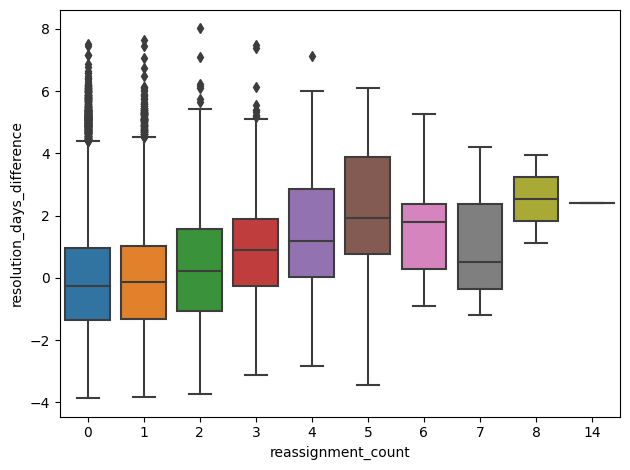

In [26]:
# Boxplot to depict the effect of ticket reassignment (multiple groups and/or agents working sequentially on the ticket)
sns.boxplot(data=df_incidents,x="reassignment_count", y="resolution_days_difference")
plt.tight_layout()
plt.savefig("ticket_reassignment_time_to_resolve.png", dpi=150)

In [27]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="reassignment_count"].round(3)

,Variable,Value,Count,Mean,Ttest,p_increase,p_decrease,Assessment
347,reassignment_count,5,33,2.086,5.080,0.000,1.000,Increased Resolution Time
345,reassignment_count,4,66,1.488,5.414,0.000,1.000,Increased Resolution Time
346,reassignment_count,3,211,1.015,7.134,0.000,1.000,Increased Resolution Time
344,reassignment_count,2,772,0.419,5.979,0.000,1.000,Increased Resolution Time
343,reassignment_count,1,5489,-0.027,-0.683,0.753,0.247,NaN
342,reassignment_count,0,13736,-0.058,-3.039,0.999,0.001,Decreased Resolution Time


Ticket reassignments between groups and support staff members increases the resolution time: 0.5 day extra for every assignment beyond the first reassignment